# Rearranging Loops to Increase Spatial Locality

## Import libs, setup db conn

In [5]:
import os
from collections import namedtuple


import pandas as pd
import numpy as np
import duckdb
import polars as pl


Benchmark = namedtuple("Benchmark", ["id", "description", "ts", "bench_type", "unit"])

def get_db_conn():
    results_dir = os.path.abspath('')
    results_db = os.path.join(results_dir, "results.db")
    conn = duckdb.connect(results_db)
    return conn



conn = get_db_conn()


## Get L1,L2,L3 positions wrt N

In [6]:
l1_size = 192 * (2 ** 10)
l2_size = 1.5 * (2 ** 20)
l3_size = 12 * (2 ** 20)
def get_N(bytes):
    import math
    return math.sqrt(bytes/24)
    
def get_approx_size_MB(N):
    size_matrix_bytes = N * N * 8
    all = size_matrix_bytes * 3
    return all / (2 ** 20)
    
l1_cutoff = get_N(l1_size)
l2_cutoff = get_N(l2_size)
l3_cutoff = get_N(l3_size)

print("l1_cutoff:", l1_cutoff)
print("l2_cutoff:", l2_cutoff)
print("l3_cutoff:", l3_cutoff)

N = 1200
print("N={}, size={}".format(N, get_approx_size_MB(N)))

# l1_cutoff: 90.50966799187809
# l2_cutoff: 256.0
# l3_cutoff: 724.0773439350247


l1_cutoff: 90.50966799187809
l2_cutoff: 256.0
l3_cutoff: 724.0773439350247
N=1200, size=32.958984375


## Helper function to get df for total & inner res

In [22]:

# latest benchmark result
def get_df(bench_type):
    bench_sql = f"""
    select * from (
        select
            id,
            last_value(description ignore nulls) over (
                order by id asc
                rows between unbounded preceding and current row
            ) as desc,
            ts_added,
            bench_type,
            unit
        from benchmark
    )where id = (select max(id) from benchmark where bench_type = '{bench_type}')
    """
    
    bench = Benchmark(*conn.sql(bench_sql).fetchone())
    print(bench)
    
    results_sql =f"""select N, fn, value from result where bench_id = {bench.id}"""
    
    df = conn.sql(results_sql).pl()
    df = df.pivot(values="value",index="N", columns="fn")
    return df






## Setup plotting

In [8]:
import plotly.express as px
import plotly.graph_objects as go

# column groupings
cols = {
    # inner loop: column-wise access of A & C
    "AC": { "names": ["jki", "kji"], "color": "#46237a"}, 
    
    # inner loop: row-wise access of A, column-wise access of B
    "AB": { "names": ["jik", "ijk"], "color": "#256eff"}, 

    # inner loop: row-wise access of B & C
    "BC": { "names": ["kij", "ikj"], "color": "#3ddc97"}, 
}


def fig_args(cols, class_):
    ys = cols[class_]["names"]
    color = cols[class_]["color"]
    colors = {y:color for y in ys}
    return {
        "x": "N",
        "y": ys,
        "markers": True,
        "color_discrete_map":colors,
    }



## Plot total cycles per fn

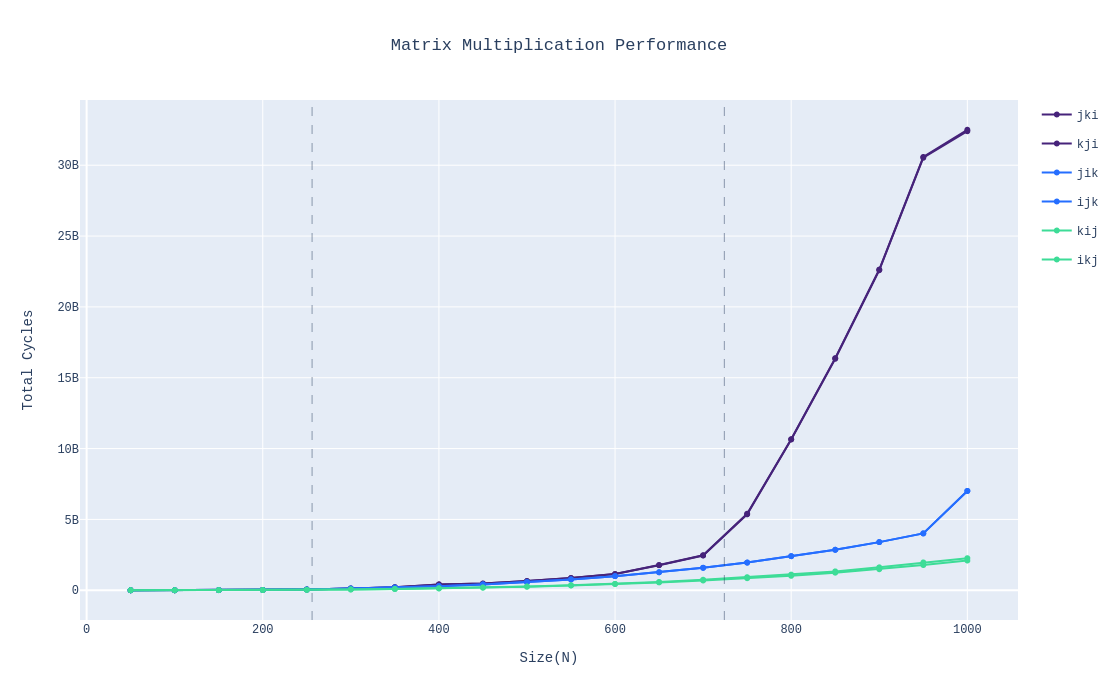

In [42]:
bench_id = 3
results_sql =f"""select N, fn, value from result where bench_id = {bench_id}"""
df = conn.sql(results_sql).pl()
df = df.pivot(values="value",index="N", columns="fn")
total_df = df.to_pandas()
figAC = px.line(total_df, **fig_args(cols, "AC"))
figAB = px.line(total_df, **fig_args(cols, "AB"))
figBC = px.line(total_df, **fig_args(cols, "BC"))

layout = {
    "font": {"family": "Courier New"},
    "title_text": "Matrix Multiplication Performance",
    "title_x": 0.5,
    "xaxis_title":"Size(N)",
    "yaxis_title":"Total Cycles",
    "height": 700
}

fig = go.Figure(layout=layout,data=figAC.data + figAB.data + figBC.data)
fig.add_vline(x=l2_cutoff, line_width=0.5, line_dash="dash")
fig.add_vline(x=l3_cutoff, line_width=0.5, line_dash="dash")
fig.show()

## Plot Cycles Per Iteration

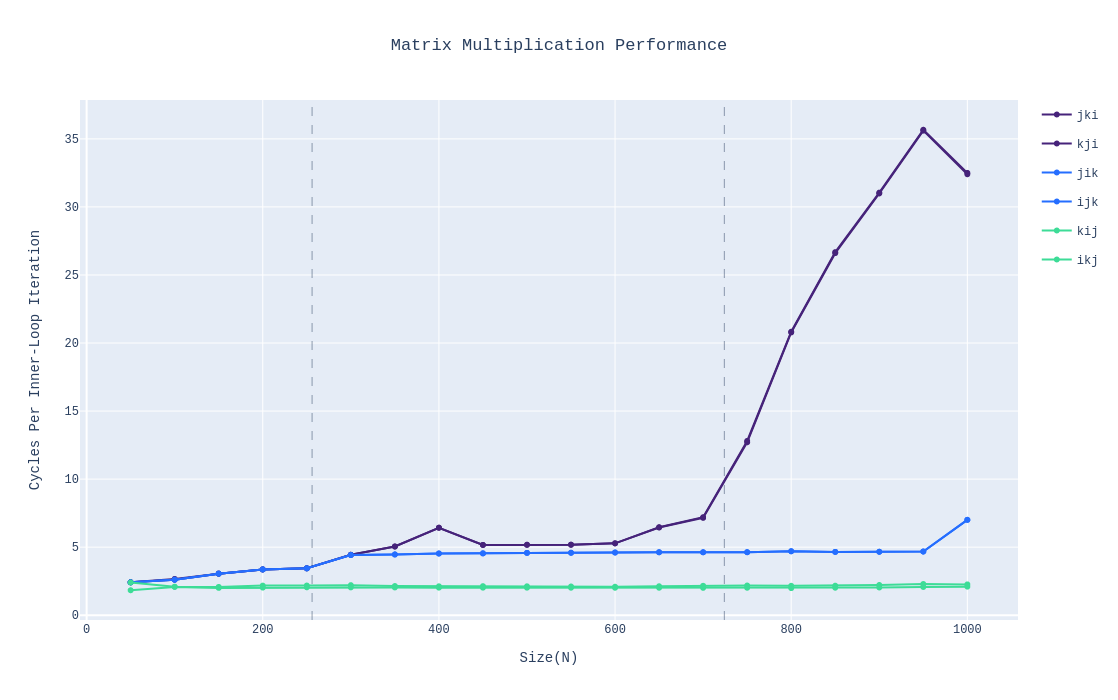

In [41]:
bench_id = 3
results_sql =f"""select N, fn, (value / (N * N * N)) as value from result where bench_id = {bench_id} and N <= 1000"""
df = conn.sql(results_sql).pl()
df = df.pivot(values="value",index="N", columns="fn")
total_df = df.to_pandas()
figAC = px.line(total_df, **fig_args(cols, "AC"))
figAB = px.line(total_df, **fig_args(cols, "AB"))
figBC = px.line(total_df, **fig_args(cols, "BC"))

layout = {
    "font": {"family": "Courier New"},
    "title_text": "Matrix Multiplication Performance",
    "title_x": 0.5,
    "xaxis_title":"Size(N)",
    "yaxis_title":"Cycles Per Inner-Loop Iteration",
    "height": 700,
}

fig = go.Figure(layout=layout,data=figAC.data + figAB.data + figBC.data)
fig.add_vline(x=l2_cutoff, line_width=0.5, line_dash="dash")
fig.add_vline(x=l3_cutoff, line_width=0.5, line_dash="dash")
fig.show()

## Plot inner-most loop cycles per fn

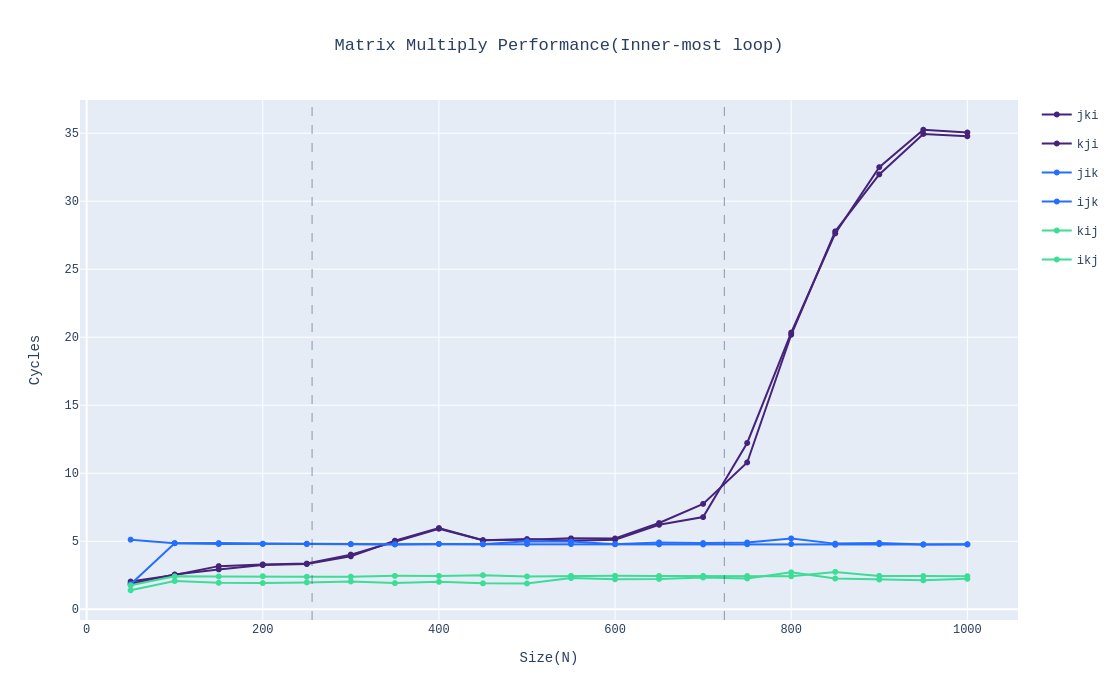

In [39]:
bench_id = 4 # final for inner-most loop
results_sql =f"""select N, fn, (value / N) as value from result where bench_id = {bench_id}"""
df = conn.sql(results_sql).pl()
df = df.pivot(values="value",index="N", columns="fn")
total_df = df.to_pandas()
figAC = px.line(total_df, **fig_args(cols, "AC"))
figAB = px.line(total_df, **fig_args(cols, "AB"))
figBC = px.line(total_df, **fig_args(cols, "BC"))

layout = {
    "font": {"family": "Courier New"},
    "title_text": "Matrix Multiply Performance(Inner-most loop)",
    "title_x": 0.5,
    "xaxis_title":"Size(N)",
    "yaxis_title":"Cycles",
    "height": 700
}

fig = go.Figure(layout=layout,data=figAC.data + figAB.data + figBC.data)
fig.add_vline(x=l2_cutoff, line_width=0.5, line_dash="dash")
fig.add_vline(x=l3_cutoff, line_width=0.5, line_dash="dash")
# fig.update_yaxes(type="log")
fig.show()

In [18]:
sql = "select id, description, bench_type from benchmark"
sql = "select * from result where bench_id = 3"
conn.sql(sql)

┌──────────┬───────┬────────────────────────────────────────────────┬───────────────┐
│ bench_id │   N   │                       fn                       │     value     │
│  int32   │ int32 │ enum('jki', 'kji', 'jik', 'ijk', 'kij', 'ikj') │    double     │
├──────────┼───────┼────────────────────────────────────────────────┼───────────────┤
│        3 │    50 │ jki                                            │      302690.0 │
│        3 │    50 │ kji                                            │      302020.0 │
│        3 │    50 │ jik                                            │      302020.0 │
│        3 │    50 │ ijk                                            │      302014.0 │
│        3 │    50 │ kij                                            │      300006.0 │
│        3 │    50 │ ikj                                            │      229122.0 │
│        3 │   100 │ jki                                            │     2668404.0 │
│        3 │   100 │ kji                              